In [1]:
%load_ext autoreload
%autoreload 2
import os
import random
import warnings
from datetime import datetime
import gdown

import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
import seaborn as sns
import squidpy as sq
from matplotlib import gridspec
from sklearn.preprocessing import MinMaxScaler

from nichecompass.models import NicheCompass
from nichecompass.utils import (add_gps_from_gp_dict_to_adata,
                                compute_communication_gp_network,
                                visualize_communication_gp_network,
                                create_new_color_dict,
                                extract_gp_dict_from_mebocost_es_interactions,
                                extract_gp_dict_from_nichenet_lrt_interactions,
                                extract_gp_dict_from_omnipath_lr_interactions,
                                filter_and_combine_gp_dict_gps,
                                generate_enriched_gp_info_plots)

/home/xu262605/anaconda3/envs/nichecompass/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
### Dataset ###
dataset = "starmap_plus_mouse_cns"
species = "mouse"
spatial_key = "spatial"
n_neighbors = 4

### Model ###
# AnnData Keys
counts_key = "counts"
adj_key = "spatial_connectivities"
gp_names_key = "nichecompass_gp_names"
active_gp_names_key = "nichecompass_active_gp_names"
gp_targets_mask_key = "nichecompass_gp_targets"
gp_targets_categories_mask_key = "nichecompass_gp_targets_categories"
gp_sources_mask_key = "nichecompass_gp_sources"
gp_sources_categories_mask_key = "nichecompass_gp_sources_categories"
latent_key = "nichecompass_latent"

# Architecture
conv_layer_encoder = "gcnconv" # change to "gatv2conv" if enough compute and memory
active_gp_thresh_ratio = 0.01

# Trainer
n_epochs = 400
n_epochs_all_gps = 25
lr = 0.001
lambda_edge_recon = 500000.
lambda_gene_expr_recon = 300.
lambda_l1_masked = 0. # increase if gene selection desired
lambda_l1_addon = 100.
edge_batch_size = 1024 # increase if more memory available
n_sampled_neighbors = 4
use_cuda_if_available = True

### Analysis ###
cell_type_key = "Main_molecular_cell_type"
latent_leiden_resolution = 0.4
latent_cluster_key = f"latent_leiden_{str(latent_leiden_resolution)}"
sample_key = "batch"
spot_size = 0.2
differential_gp_test_results_key = "nichecompass_differential_gp_test_results"

In [3]:
warnings.filterwarnings("ignore")

In [4]:
# Get time of notebook execution for timestamping saved artifacts
now = datetime.now()
current_timestamp = now.strftime("%d%m%Y_%H%M%S")

In [5]:
# Define paths
ga_data_folder_path = "/work/rwth1209/dana_projects/spatial_domain_tools/NicheCompass/nichecompass-reproducibility/datasets/ga_data"
gp_data_folder_path = "/work/rwth1209/dana_projects/spatial_domain_tools/NicheCompass/nichecompass-reproducibility/datasets/gp_data"
so_data_folder_path = "../../../data/spatial_omics"
omnipath_lr_network_file_path = f"{gp_data_folder_path}/omnipath_lr_network.csv"
collectri_tf_network_file_path = f"{gp_data_folder_path}/collectri_tf_network_{species}.csv"
nichenet_lr_network_file_path = f"{gp_data_folder_path}/nichenet_lr_network_v2_{species}.csv"
nichenet_ligand_target_matrix_file_path = f"{gp_data_folder_path}/nichenet_ligand_target_matrix_v2_{species}.csv"
mebocost_enzyme_sensor_interactions_folder_path = f"{gp_data_folder_path}/metabolite_enzyme_sensor_gps"
gene_orthologs_mapping_file_path = f"{ga_data_folder_path}/human_mouse_gene_orthologs.csv"
artifacts_folder_path = f"/work/rwth1209/dana_projects/spatial_domain_tools/NicheCompass/tutorial"
model_folder_path = f"{artifacts_folder_path}/single_sample/{current_timestamp}/model"
figure_folder_path = f"{artifacts_folder_path}/single_sample/{current_timestamp}/figures"

In [6]:
os.makedirs(model_folder_path, exist_ok=True)
os.makedirs(figure_folder_path, exist_ok=True)
os.makedirs(so_data_folder_path, exist_ok=True)

In [7]:
gdown.download('https://drive.google.com/uc?id=1MOjIyue7a-JDAcnAseqIljDyoO7KtH99', so_data_folder_path+'/starmap_plus_mouse_cns_batch1.h5ad')

Downloading...
From (original): https://drive.google.com/uc?id=1MOjIyue7a-JDAcnAseqIljDyoO7KtH99
From (redirected): https://drive.google.com/uc?id=1MOjIyue7a-JDAcnAseqIljDyoO7KtH99&confirm=t&uuid=67f96e22-0a5f-40a0-967d-5ad8e27f5d9e
To: /rwthfs/rz/cluster/work/rwth1209/dana_projects/data/spatial_omics/starmap_plus_mouse_cns_batch1.h5ad
100%|██████████| 123M/123M [00:03<00:00, 36.4MB/s] 


'../../../data/spatial_omics/starmap_plus_mouse_cns_batch1.h5ad'

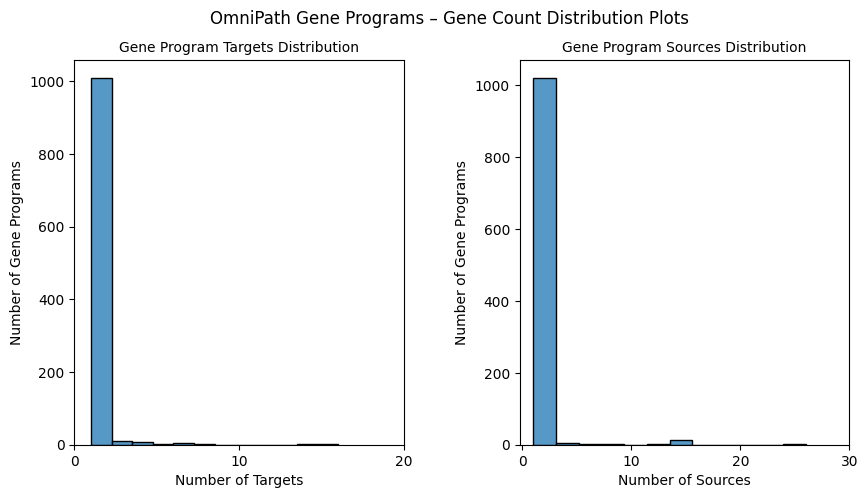

In [8]:
# Retrieve OmniPath GPs (source: ligand genes; target: receptor genes)
omnipath_gp_dict = extract_gp_dict_from_omnipath_lr_interactions(
    species=species,
    min_curation_effort=0,
    load_from_disk=False,
    save_to_disk=True,
    lr_network_file_path=omnipath_lr_network_file_path,
    gene_orthologs_mapping_file_path=gene_orthologs_mapping_file_path,
    plot_gp_gene_count_distributions=True,
    gp_gene_count_distributions_save_path=f"{figure_folder_path}" \
                                           "/omnipath_gp_gene_count_distributions.svg")

In [9]:
# Display example OmniPath GP
omnipath_gp_names = list(omnipath_gp_dict.keys())
random.shuffle(omnipath_gp_names)
omnipath_gp_name = omnipath_gp_names[0]
print(f"{omnipath_gp_name}: {omnipath_gp_dict[omnipath_gp_name]}")

NECTIN2_ligand_receptor_GP: {'sources': ['Nectin2'], 'targets': ['Pard3'], 'sources_categories': ['ligand'], 'targets_categories': ['receptor']}


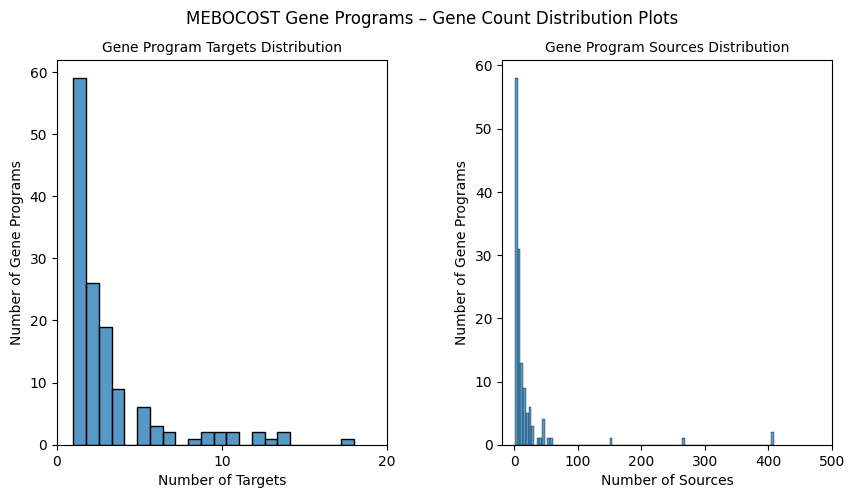

In [10]:
# Retrieve MEBOCOST GPs (source: enzyme genes; target: sensor genes)
mebocost_gp_dict = extract_gp_dict_from_mebocost_es_interactions(
    dir_path=mebocost_enzyme_sensor_interactions_folder_path,
    species=species,
    plot_gp_gene_count_distributions=True)

In [11]:
# Display example MEBOCOST GP
mebocost_gp_names = list(mebocost_gp_dict.keys())
random.shuffle(mebocost_gp_names)
mebocost_gp_name = mebocost_gp_names[0]
print(f"{mebocost_gp_name}: {mebocost_gp_dict[mebocost_gp_name]}")

Dihydrotestosterone_metabolite_enzyme_sensor_GP: {'sources': ['Akr1c12', 'Akr1c13', 'Akr1c14', 'Akr1c18', 'Akr1c19', 'Akr1c20', 'Akr1c21', 'Akr1c6', 'Akr1cl', 'Srd5a1', 'Srd5a2', 'Srd5a3'], 'sources_categories': ['enzyme', 'enzyme', 'enzyme', 'enzyme', 'enzyme', 'enzyme', 'enzyme', 'enzyme', 'enzyme', 'enzyme', 'enzyme', 'enzyme'], 'targets': ['Ar', 'Glp1r'], 'targets_categories': ['sensor', 'sensor']}


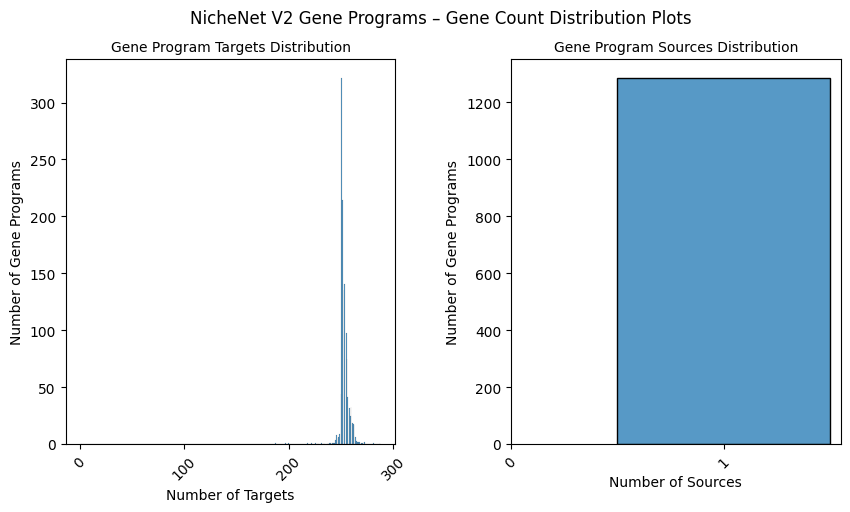

In [12]:
# Retrieve NicheNet GPs (source: ligand genes; target: receptor genes, target genes)
nichenet_gp_dict = extract_gp_dict_from_nichenet_lrt_interactions(
    species=species,
    version="v2",
    keep_target_genes_ratio=1.,
    max_n_target_genes_per_gp=250,
    load_from_disk=False,
    save_to_disk=True,
    lr_network_file_path=nichenet_lr_network_file_path,
    ligand_target_matrix_file_path=nichenet_ligand_target_matrix_file_path,
    gene_orthologs_mapping_file_path=gene_orthologs_mapping_file_path,
    plot_gp_gene_count_distributions=True)

In [13]:
# Display example NicheNet GP
nichenet_gp_names = list(nichenet_gp_dict.keys())
random.shuffle(nichenet_gp_names)
nichenet_gp_name = nichenet_gp_names[0]
print(f"{nichenet_gp_name}: {nichenet_gp_dict[nichenet_gp_name]}")

Epha4_ligand_receptor_target_gene_GP: {'sources': ['Epha4'], 'targets': ['Fgfr1', 'Fgfr2', 'Fgfr3', 'Fgfr4', 'A2m', 'Abcb1a', 'Abcb1b', 'Acta2', 'Adh1', 'Adk', 'Adra2a', 'Aldh1a3', 'Angpt2', 'Ank2', 'Arhgap24', 'Aspscr1', 'Atad2', 'Atp1b1', 'Aurkb', 'Axin2', 'Azin1', 'B3galt2', 'Bcat2', 'Bcl11a', 'Bcl3', 'Bdnf', 'Birc5', 'Bmp4', 'Bmp5', 'Btg2', 'Cacna1d', 'Cap2', 'Capg', 'Cavin2', 'Ccl12', 'Ccnd1', 'Ccnd2', 'Ccr7', 'Cd44', 'Cd83', 'Cdca7', 'Cdh13', 'Cdkn1a', 'Cemip2', 'Cenpa', 'Ckap2', 'Clec2m', 'Clu', 'Cobl', 'Corin', 'Creb5', 'Crmp1', 'Ctdspl', 'Ctnnb1', 'Cxcl12', 'Cyfip2', 'Cyp26a1', 'Cyp3a11', 'Cyp3a13', 'Cyp3a16', 'Cyp3a41a', 'Cyp3a41b', 'Cyp3a44', 'Cyp4f13', 'Cyp4f15', 'Dtl', 'E2f1', 'Eef1a1', 'Elapor1', 'Elf3', 'Ell2', 'Enpep', 'Ep300', 'Epc1', 'Epha4', 'Epha7', 'Esm1', 'Esr1', 'Esr2', 'Exo1', 'F10', 'F9', 'Fcgr1', 'Fgf1', 'Fgf2', 'Fgf9', 'Fgl1', 'Fnbp1', 'Fos', 'Foxo1', 'Frk', 'Frmd4b', 'Gadd45a', 'Gadd45b', 'Gata3', 'Gbe1', 'Gnas', 'Gnl3', 'Gpr37', 'Gpr65', 'Gsk3b', 'Gsta3', '

In [14]:
# Add GPs into one combined dictionary for model training
combined_gp_dict = dict(omnipath_gp_dict)
combined_gp_dict.update(mebocost_gp_dict)
combined_gp_dict.update(nichenet_gp_dict)

In [15]:
# Filter and combine GPs to avoid overlaps
combined_new_gp_dict = filter_and_combine_gp_dict_gps(
    gp_dict=combined_gp_dict,
    gp_filter_mode="subset",
    combine_overlap_gps=True,
    overlap_thresh_source_genes=0.9,
    overlap_thresh_target_genes=0.9,
    overlap_thresh_genes=0.9)

print("Number of gene programs before filtering and combining: "
      f"{len(combined_gp_dict)}.")
print(f"Number of gene programs after filtering and combining: "
      f"{len(combined_new_gp_dict)}.")

Number of gene programs before filtering and combining: 2466.
Number of gene programs after filtering and combining: 2094.


In [16]:
# Read data
adata = sc.read_h5ad(
        f"{so_data_folder_path}/{dataset}_batch1.h5ad")

In [17]:
# Compute spatial neighborhood
sq.gr.spatial_neighbors(adata,
                        coord_type="generic",
                        spatial_key=spatial_key,
                        n_neighs=n_neighbors)

# Make adjacency matrix symmetric
adata.obsp[adj_key] = (
    adata.obsp[adj_key].maximum(
        adata.obsp[adj_key].T))

In [18]:
# Add the GP dictionary as binary masks to the adata
add_gps_from_gp_dict_to_adata(
    gp_dict=combined_new_gp_dict,
    adata=adata,
    gp_targets_mask_key=gp_targets_mask_key,
    gp_targets_categories_mask_key=gp_targets_categories_mask_key,
    gp_sources_mask_key=gp_sources_mask_key,
    gp_sources_categories_mask_key=gp_sources_categories_mask_key,
    gp_names_key=gp_names_key,
    min_genes_per_gp=2,
    min_source_genes_per_gp=1,
    min_target_genes_per_gp=1,
    max_genes_per_gp=None,
    max_source_genes_per_gp=None,
    max_target_genes_per_gp=None)

In [19]:
cell_type_colors = create_new_color_dict(
    adata=adata,
    cat_key=cell_type_key)

Number of nodes (observations): 91246
Number of node features (genes): 1022


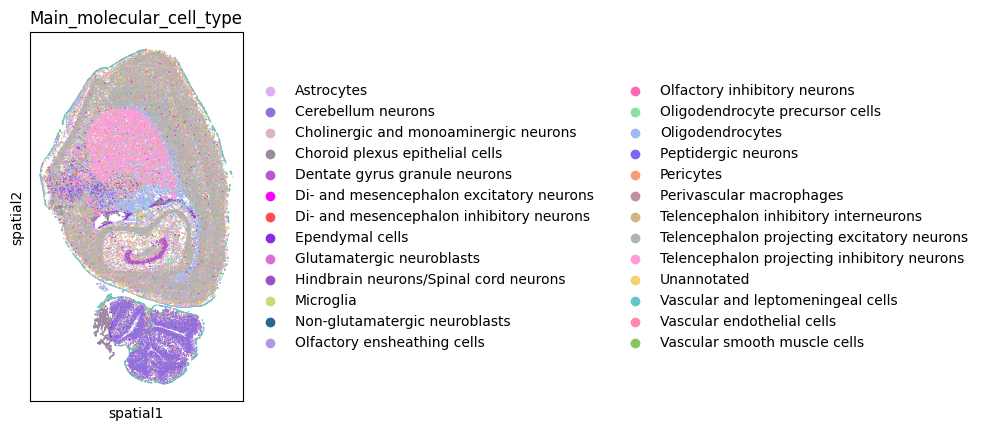

In [20]:
print(f"Number of nodes (observations): {adata.layers['counts'].shape[0]}")
print(f"Number of node features (genes): {adata.layers['counts'].shape[1]}")

# Visualize cell-level annotated data in physical space
sc.pl.spatial(adata,
              color=cell_type_key,
              palette=cell_type_colors,
              spot_size=spot_size)        

In [21]:
# Initialize model
model = NicheCompass(adata,
                     counts_key=counts_key,
                     adj_key=adj_key,
                     gp_names_key=gp_names_key,
                     active_gp_names_key=active_gp_names_key,
                     gp_targets_mask_key=gp_targets_mask_key,
                     gp_targets_categories_mask_key=gp_targets_categories_mask_key,
                     gp_sources_mask_key=gp_sources_mask_key,
                     gp_sources_categories_mask_key=gp_sources_categories_mask_key,
                     latent_key=latent_key,
                     conv_layer_encoder=conv_layer_encoder,
                     active_gp_thresh_ratio=active_gp_thresh_ratio)

--- INITIALIZING NEW NETWORK MODULE: VARIATIONAL GENE PROGRAM GRAPH AUTOENCODER ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True, rna_recon_loss: nb
NODE LABEL METHOD -> one-hop-norm
ACTIVE GP THRESHOLD RATIO -> 0.01
LOG VARIATIONAL -> True
ONE HOP GCN NORM RNA NODE LABEL AGGREGATOR
ENCODER -> n_input: 1022, n_cat_covariates_embed_input: 0, n_hidden: 313, n_latent: 213, n_addon_latent: 100, n_fc_layers: 1, n_layers: 1, conv_layer: gcnconv, n_attention_heads: 0, dropout_rate: 0.0, 
COSINE SIM GRAPH DECODER -> dropout_rate: 0.0
MASKED TARGET RNA DECODER -> n_prior_gp_input: 213, n_addon_gp_input: 100, n_cat_covariates_embed_input: 0, n_output: 1022
MASKED SOURCE RNA DECODER -> n_prior_gp_input: 213, n_addon_gp_input: 100, n_cat_covariates_embed_input: 0, n_output: 1022


In [22]:
adata

AnnData object with n_obs × n_vars = 91246 × 1022
    obs: 'Main_molecular_cell_type', 'Sub_molecular_cell_type', 'Main_molecular_tissue_region', 'Sub_molecular_tissue_region', 'Molecular_spatial_cell_type', 'batch'
    uns: 'log1p', 'spatial_neighbors', 'nichecompass_sources_categories_label_encoder', 'nichecompass_targets_categories_label_encoder', 'nichecompass_source_genes_idx', 'nichecompass_target_genes_idx', 'nichecompass_genes_idx', 'nichecompass_gp_names', 'Main_molecular_cell_type_colors'
    obsm: 'spatial'
    varm: 'nichecompass_gp_sources', 'nichecompass_gp_targets', 'nichecompass_gp_sources_categories', 'nichecompass_gp_targets_categories'
    layers: 'counts'
    obsp: 'spatial_connectivities', 'spatial_distances'

In [23]:
adata.X

<91246x1022 sparse matrix of type '<class 'numpy.float32'>'
	with 7202529 stored elements in Compressed Sparse Row format>

In [24]:
adata.layers['counts']

<91246x1022 sparse matrix of type '<class 'numpy.float32'>'
	with 7202529 stored elements in Compressed Sparse Row format>

In [26]:
adata.layers['counts'].max()

293.0

In [27]:
adata.uns['nichecompass_gp_names']

array(['IGF2_ligand_receptor_GP', 'GRP_ligand_receptor_GP',
       'CCK_ligand_receptor_GP', 'PDYN_ligand_receptor_GP',
       'PENK_ligand_receptor_GP', 'NMU_ligand_receptor_GP',
       'VIP_ligand_receptor_GP', 'CORT_ligand_receptor_GP',
       'SST_ligand_receptor_GP',
       'Adenosine monophosphate_metabolite_enzyme_sensor_GP',
       'Adenosine_metabolite_enzyme_sensor_GP',
       'Dopamine_metabolite_enzyme_sensor_GP',
       'Choline_metabolite_enzyme_sensor_GP',
       'gamma-Aminobutyric acid_metabolite_enzyme_sensor_GP',
       'L-Glutamic acid_metabolite_enzyme_sensor_GP',
       'L-Serine_metabolite_enzyme_sensor_GP',
       'Norepinephrine_metabolite_enzyme_sensor_GP',
       'Serotonin_metabolite_enzyme_sensor_GP',
       'Adenosine triphosphate_metabolite_enzyme_sensor_GP',
       'Histamine_metabolite_enzyme_sensor_GP',
       'Acetylcholine_metabolite_enzyme_sensor_GP',
       'ADP_metabolite_enzyme_sensor_GP',
       'Melatonin_metabolite_enzyme_sensor_GP',
       'A

In [38]:
adata.varm['nichecompass_gp_sources'][0].shape

(213,)

In [37]:
adata.varm['nichecompass_gp_sources']

TypeError: 'tuple' object is not callable

In [34]:
len(adata.varm['nichecompass_gp_targets'])

1022

In [ ]:
# Train model
model.train(n_epochs=n_epochs,
            n_epochs_all_gps=n_epochs_all_gps,
            lr=lr,
            lambda_edge_recon=lambda_edge_recon,
            lambda_gene_expr_recon=lambda_gene_expr_recon,
            lambda_l1_masked=lambda_l1_masked,
            edge_batch_size=edge_batch_size,
            n_sampled_neighbors=n_sampled_neighbors,
            use_cuda_if_available=use_cuda_if_available,
            verbose=False)

In [ ]:
# Compute latent neighbor graph
sc.pp.neighbors(model.adata,
                use_rep=latent_key,
                key_added=latent_key)

# Compute UMAP embedding
sc.tl.umap(model.adata,
           neighbors_key=latent_key)

In [ ]:
# Compute latent neighbor graph
sc.pp.neighbors(model.adata,
                use_rep=latent_key,
                key_added=latent_key)

# Compute UMAP embedding
sc.tl.umap(model.adata,
           neighbors_key=latent_key)

In [ ]:
# Save trained model
model.save(dir_path=model_folder_path,
           overwrite=True,
           save_adata=True,
           adata_file_name="adata.h5ad")

# Tutorial part 2 

In [7]:
load_timestamp = "07052024_151101"
artifacts_folder_path = f"/work/rwth1209/dana_projects/spatial_domain_tools/NicheCompass/tutorial/"

figure_folder_path = f"{artifacts_folder_path}/single_sample/{load_timestamp}/figures"
model_folder_path = f"{artifacts_folder_path}/single_sample/{load_timestamp}/model"

os.makedirs(figure_folder_path, exist_ok=True)

In [8]:
# Load trained model
model = NicheCompass.load(dir_path=model_folder_path,
                          adata=None,
                          adata_file_name="adata.h5ad",
                          gp_names_key=gp_names_key)

--- INITIALIZING NEW NETWORK MODULE: VARIATIONAL GENE PROGRAM GRAPH AUTOENCODER ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True, rna_recon_loss: nb
NODE LABEL METHOD -> one-hop-norm
ACTIVE GP THRESHOLD RATIO -> 0.01
LOG VARIATIONAL -> True
ONE HOP GCN NORM RNA NODE LABEL AGGREGATOR
ENCODER -> n_input: 1022, n_cat_covariates_embed_input: 0, n_hidden: 313, n_latent: 213, n_addon_latent: 100, n_fc_layers: 1, n_layers: 1, conv_layer: gcnconv, n_attention_heads: 0, dropout_rate: 0.0, 
COSINE SIM GRAPH DECODER -> dropout_rate: 0.0
MASKED TARGET RNA DECODER -> n_prior_gp_input: 213, n_addon_gp_input: 100, n_cat_covariates_embed_input: 0, n_output: 1022
MASKED SOURCE RNA DECODER -> n_prior_gp_input: 213, n_addon_gp_input: 100, n_cat_covariates_embed_input: 0, n_output: 1022


In [9]:
samples = model.adata.obs[sample_key].unique().tolist()

In [10]:
cell_type_colors = create_new_color_dict(
    adata=model.adata,
    cat_key=cell_type_key)

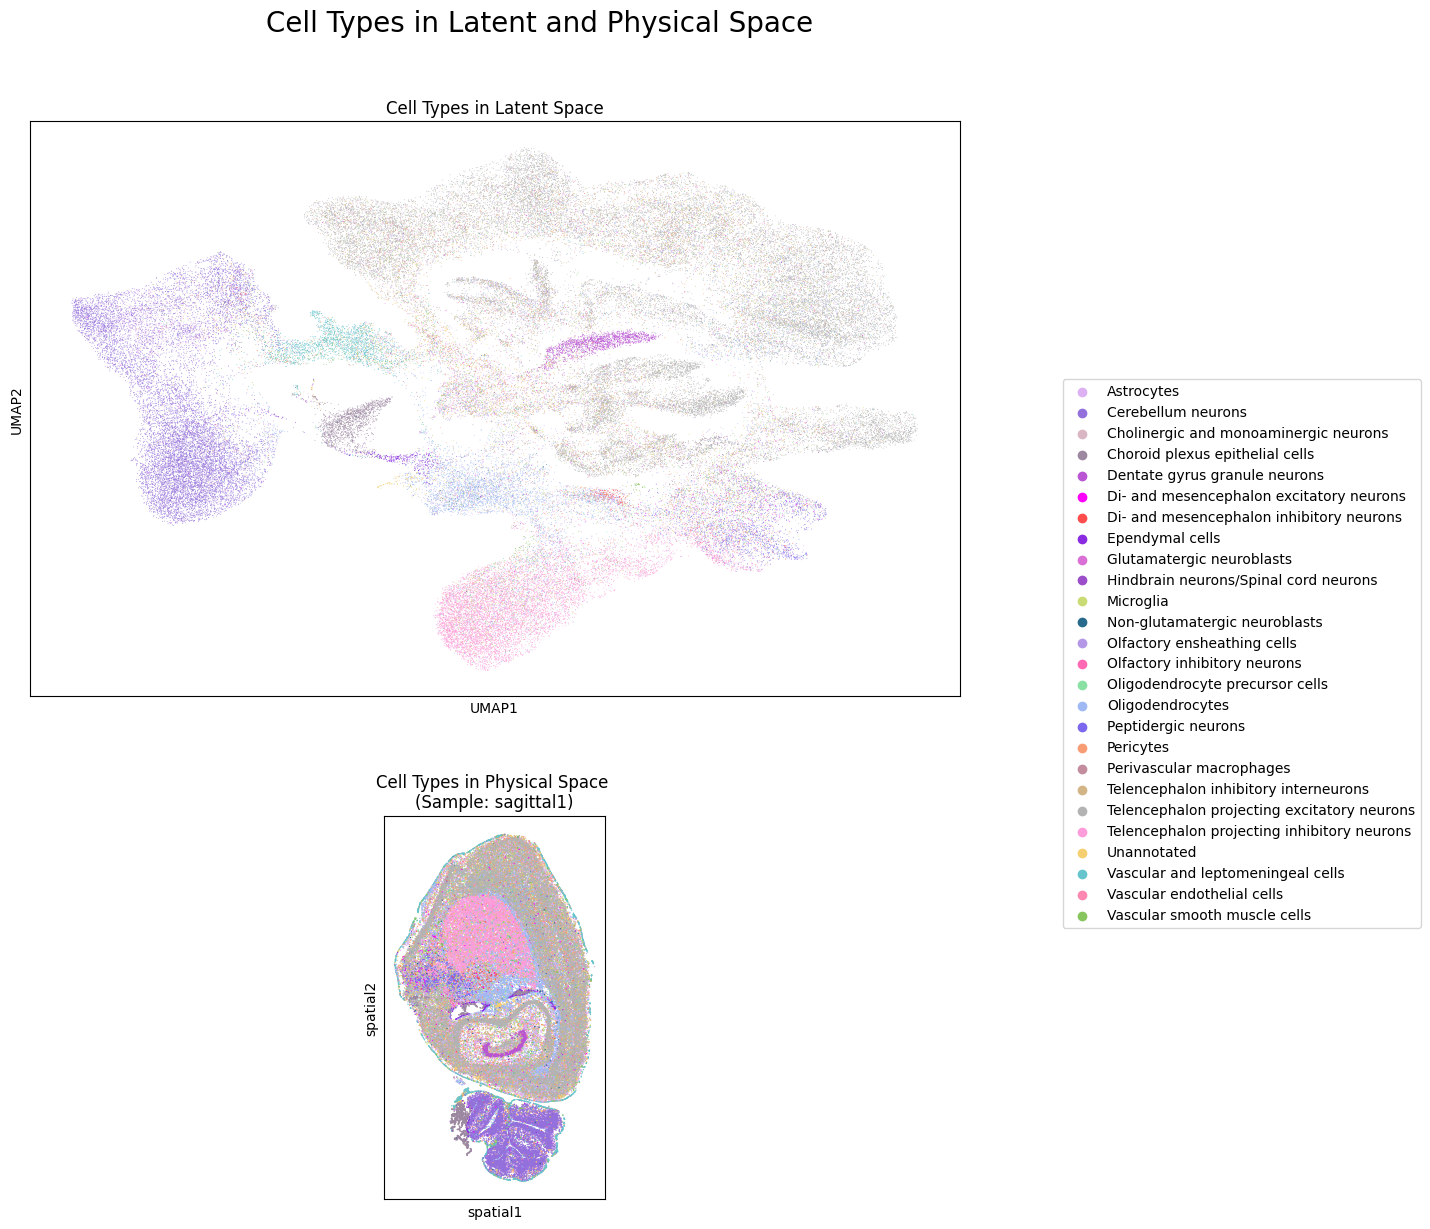

In [11]:
# Create plot of cell type annotations in physical and latent space
groups = None
save_fig = True
file_path = f"{figure_folder_path}/" \
            "cell_types_latent_physical_space.svg"

fig = plt.figure(figsize=(12, 14))
title = fig.suptitle(t=f"Cell Types " \
                       "in Latent and Physical Space",
                     y=0.96,
                     x=0.55,
                     fontsize=20)
spec1 = gridspec.GridSpec(ncols=1,
                          nrows=2,
                          width_ratios=[1],
                          height_ratios=[3, 2])
spec2 = gridspec.GridSpec(ncols=len(samples),
                          nrows=2,
                          width_ratios=[1] * len(samples),
                          height_ratios=[3, 2])
axs = []
axs.append(fig.add_subplot(spec1[0]))
sc.pl.umap(adata=model.adata,
           color=[cell_type_key],
           groups=groups,palette=cell_type_colors,
           title=f"Cell Types in Latent Space",
           ax=axs[0],
           show=False)
for idx, sample in enumerate(samples):
    axs.append(fig.add_subplot(spec2[len(samples) + idx]))
    sc.pl.spatial(adata=model.adata[model.adata.obs[sample_key] == sample],
                  color=[cell_type_key],
                  groups=groups,
                  palette=cell_type_colors,
                  spot_size=spot_size,
                  title=f"Cell Types in Physical Space \n"
                        f"(Sample: {sample})",
                  legend_loc=None,
                  ax=axs[idx+1],
                  show=False)

# Create and position shared legend
handles, labels = axs[0].get_legend_handles_labels()
lgd = fig.legend(handles,
                 labels,
                 loc="center left",
                 bbox_to_anchor=(0.98, 0.5))
axs[0].get_legend().remove()

# Adjust, save and display plot
plt.subplots_adjust(wspace=0.2, hspace=0.25)
if save_fig:
    fig.savefig(file_path,
                bbox_extra_artists=(lgd, title),
                bbox_inches="tight")
plt.show()

# Identify Niches

In [13]:
# Compute latent Leiden clustering
sc.tl.leiden(adata=model.adata,
             resolution=latent_leiden_resolution,
             key_added=latent_cluster_key,
             neighbors_key=latent_key)

In [14]:
latent_cluster_colors = create_new_color_dict(
    adata=model.adata,
    cat_key=latent_cluster_key)

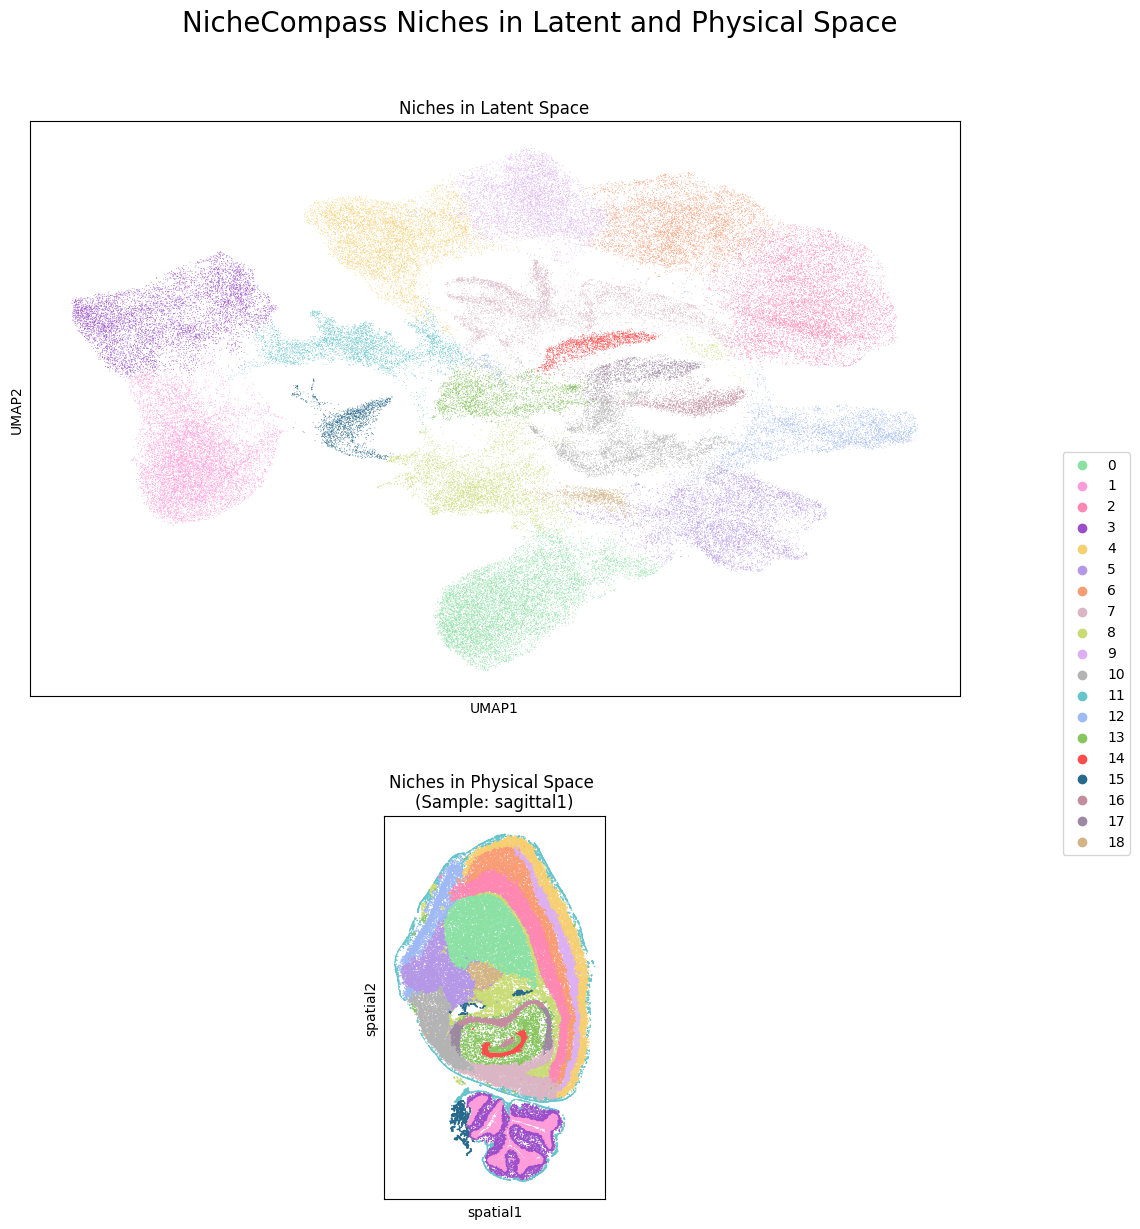

In [15]:
# Create plot of latent cluster / niche annotations in physical and latent space
groups = None # set this to a specific cluster for easy visualization, e.g. ["17"]
save_fig = True
file_path = f"{figure_folder_path}/" \
            f"res_{latent_leiden_resolution}_" \
            "niches_latent_physical_space.svg"

fig = plt.figure(figsize=(12, 14))
title = fig.suptitle(t=f"NicheCompass Niches " \
                       "in Latent and Physical Space",
                     y=0.96,
                     x=0.55,
                     fontsize=20)
spec1 = gridspec.GridSpec(ncols=1,
                          nrows=2,
                          width_ratios=[1],
                          height_ratios=[3, 2])
spec2 = gridspec.GridSpec(ncols=len(samples),
                          nrows=2,
                          width_ratios=[1] * len(samples),
                          height_ratios=[3, 2])
axs = []
axs.append(fig.add_subplot(spec1[0]))
sc.pl.umap(adata=model.adata,
           color=[latent_cluster_key],
           groups=groups,
           palette=latent_cluster_colors,
           title=f"Niches in Latent Space",
           ax=axs[0],
           show=False)
for idx, sample in enumerate(samples):
    axs.append(fig.add_subplot(spec2[len(samples) + idx]))
    sc.pl.spatial(adata=model.adata[model.adata.obs[sample_key] == sample],
                  color=[latent_cluster_key],
                  groups=groups,
                  palette=latent_cluster_colors,
                  spot_size=spot_size,
                  title=f"Niches in Physical Space \n"
                        f"(Sample: {sample})",
                  legend_loc=None,
                  ax=axs[idx+1],
                  show=False)

# Create and position shared legend
handles, labels = axs[0].get_legend_handles_labels()
lgd = fig.legend(handles,
                 labels,
                 loc="center left",
                 bbox_to_anchor=(0.98, 0.5))
axs[0].get_legend().remove()

# Adjust, save and display plot
plt.subplots_adjust(wspace=0.2, hspace=0.25)
if save_fig:
    fig.savefig(file_path,
                bbox_extra_artists=(lgd, title),
                bbox_inches="tight")
plt.show()

# Niche Composition

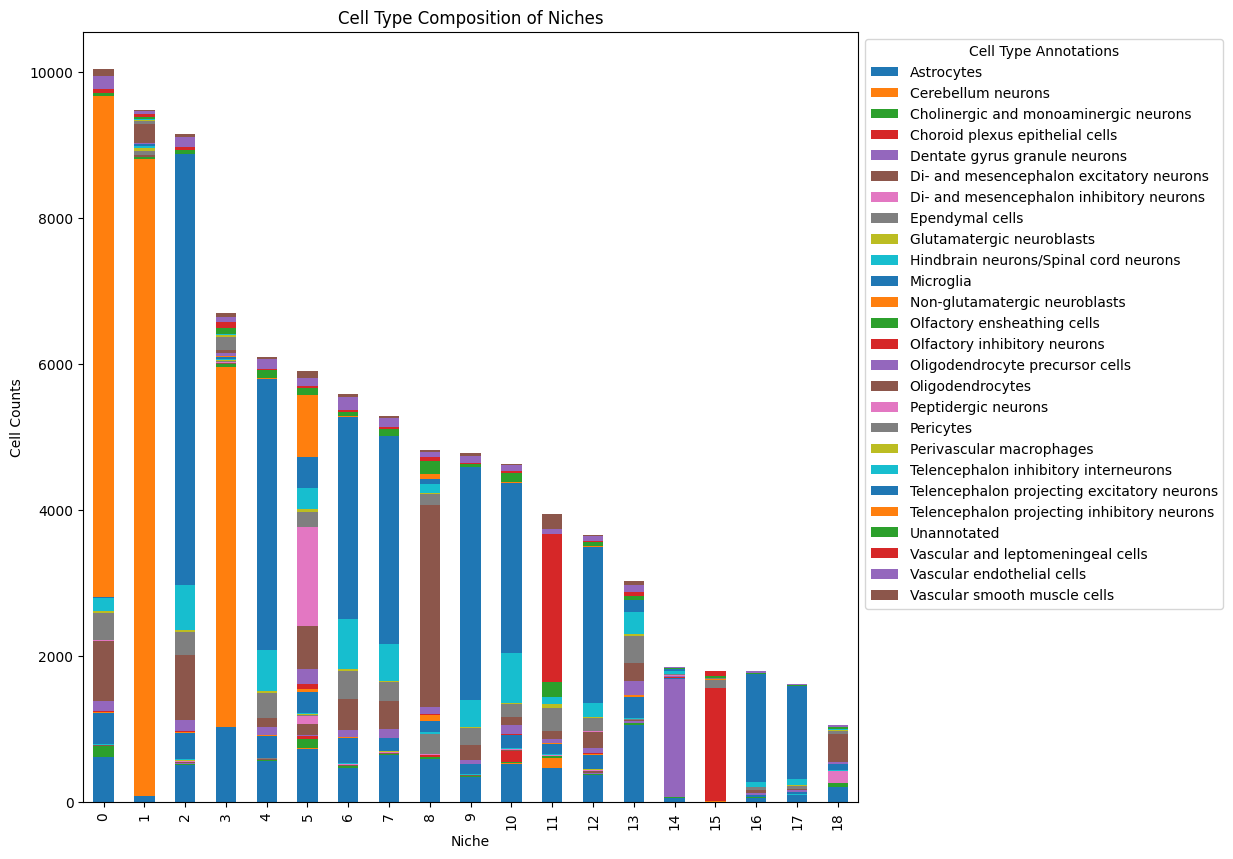

In [16]:
save_fig = True
file_path = f"{figure_folder_path}/" \
            f"res_{latent_leiden_resolution}_" \
            f"niche_composition.svg"

df_counts = (model.adata.obs.groupby([latent_cluster_key, cell_type_key])
             .size().unstack())
df_counts.plot(kind="bar", stacked=True, figsize=(10,10))
legend = plt.legend(bbox_to_anchor=(1, 1), loc="upper left", prop={'size': 10})
legend.set_title("Cell Type Annotations", prop={'size': 10})
plt.title("Cell Type Composition of Niches")
plt.xlabel("Niche")
plt.ylabel("Cell Counts")
if save_fig:
    plt.savefig(file_path,
                bbox_extra_artists=(legend,),
                bbox_inches="tight")

In [17]:
# Check number of active GPs
active_gps = model.get_active_gps()
print(f"Number of total gene programs: {len(model.adata.uns[gp_names_key])}.")
print(f"Number of active gene programs: {len(active_gps)}.")


Number of total gene programs: 313.
Number of active gene programs: 313.


In [18]:
# Display example active GPs
gp_summary_df = model.get_gp_summary()
gp_summary_df[gp_summary_df["gp_active"] == True].head()

gp_name  all_gp_idx  gp_active  active_gp_idx  \
0  IGF2_ligand_receptor_GP           0       True              0   
1   GRP_ligand_receptor_GP           1       True              1   
2   CCK_ligand_receptor_GP           2       True              2   
3  PDYN_ligand_receptor_GP           3       True              3   
4  PENK_ligand_receptor_GP           4       True              4   

   n_source_genes  n_non_zero_source_genes  n_target_genes  \
0               1                        1               1   
1               1                        1               1   
2               1                        1               1   
3               1                        1               1   
4               1                        1               1   

   n_non_zero_target_genes gp_source_genes gp_target_genes  \
0                        1          [IGF2]         [S1PR1]   
1                        1           [GRP]        [HSPA1A]   
2                        1           [CCK]          [CNR1]   
3                        1          [PDYN]         [OPRL1]   
4                        1          [PENK]          [GHSR]   

  gp_source_genes_weights gp_target_genes_weights gp_source_genes_importances  \
0                [0.3245]               [-0.0148]                    [0.9564]   
1                 [0.044]                [0.0109]                    [0.8017]   
2               [-1.0954]                [0.4508]                    [0.7084]   
3                [1.5345]                [0.2254]                    [0.8719]   
4               [-0.7065]                [0.0223]                    [0.9694]   

  gp_target_genes_importances  
0                    [0.0436]  
1                    [0.1983]  
2                    [0.2916]  
3                    [0.1281]  
4                    [0.0306]

In [19]:
# Set parameters for differential gp testing
selected_cats = ["17"]
comparison_cats = "rest"
title = f"NicheCompass Strongly Enriched Niche GPs"
log_bayes_factor_thresh = 2.3
save_fig = True
file_path = f"{figure_folder_path}/" \
            f"/log_bayes_factor_{log_bayes_factor_thresh}" \
             "_niches_enriched_gps_heatmap.svg"

In [20]:
# Run differential gp testing
enriched_gps = model.run_differential_gp_tests(
    cat_key=latent_cluster_key,
    selected_cats=selected_cats,
    comparison_cats=comparison_cats,
    log_bayes_factor_thresh=log_bayes_factor_thresh)

In [21]:
# Results are stored in a df in the adata object
model.adata.uns[differential_gp_test_results_key]

category                            gene_program      p_h0      p_h1  \
0        17                  GRP_ligand_receptor_GP  0.987622  0.012378   
1        17      Vwf_ligand_receptor_target_gene_GP  0.985382  0.014618   
2        17     Prlh_ligand_receptor_target_gene_GP  0.015763  0.984237   
3        17                 CORT_ligand_receptor_GP  0.977347  0.022653   
4        17      Grp_ligand_receptor_target_gene_GP  0.970552  0.029448   
5        17                            Add-on_67_GP  0.034790  0.965210   
6        17    Calcb_ligand_receptor_target_gene_GP  0.963535  0.036465   
7        17                            Add-on_44_GP  0.963448  0.036552   
8        17   Sema3e_ligand_receptor_target_gene_GP  0.960182  0.039818   
9        17    Rspo3_ligand_receptor_target_gene_GP  0.956830  0.043170   
10       17    Dopamine_metabolite_enzyme_sensor_GP  0.048876  0.951124   
11       17     Nppc_ligand_receptor_target_gene_GP  0.055216  0.944784   
12       17  Col12a1_ligand_receptor_target_gene_GP  0.942067  0.057933   
13       17     Myoc_ligand_receptor_target_gene_GP  0.941496  0.058504   
14       17    Anpep_ligand_receptor_target_gene_GP  0.939880  0.060120   
15       17      Cfh_ligand_receptor_target_gene_GP  0.060212  0.939788   
16       17   Sema3a_ligand_receptor_target_gene_GP  0.060343  0.939657   
17       17                            Add-on_75_GP  0.068029  0.931971   
18       17      Mpz_ligand_receptor_target_gene_GP  0.071542  0.928458   
19       17                            Add-on_65_GP  0.076770  0.923230   
20       17                            Add-on_42_GP  0.923034  0.076966   
21       17  Sostdc1_ligand_receptor_target_gene_GP  0.920454  0.079546   
22       17     Ccl3_ligand_receptor_target_gene_GP  0.920329  0.079671   
23       17  Igfbpl1_ligand_receptor_target_gene_GP  0.083531  0.916469   
24       17    Nxph2_ligand_receptor_target_gene_GP  0.913516  0.086484   
25       17    Nxph1_ligand_receptor_target_gene_GP  0.912655  0.087345   
26       17                             Add-on_0_GP  0.088501  0.911499   
27       17      Tnf_ligand_receptor_target_gene_GP  0.089266  0.910734   
28       17   S100a4_ligand_receptor_target_gene_GP  0.090684  0.909316   
29       17      Oxt_ligand_receptor_target_gene_GP  0.090773  0.909227   

    log_bayes_factor  
0           4.379368  
1           4.210784  
2          -4.134227  
3           3.764560  
4           3.495228  
5          -3.323012  
6           3.274250  
7           3.271789  
8           3.182793  
9           3.098488  
10         -2.968354  
11         -2.839699  
12          2.788791  
13          2.778374  
14          2.749405  
15         -2.747777  
16         -2.745469  
17         -2.617371  
18         -2.563238  
19         -2.487066  
20          2.484298  
21          2.448531  
22          2.446821  
23         -2.395314  
24          2.357343  
25          2.346490  
26         -2.332081  
27         -2.322635  
28         -2.305310  
29         -2.304230

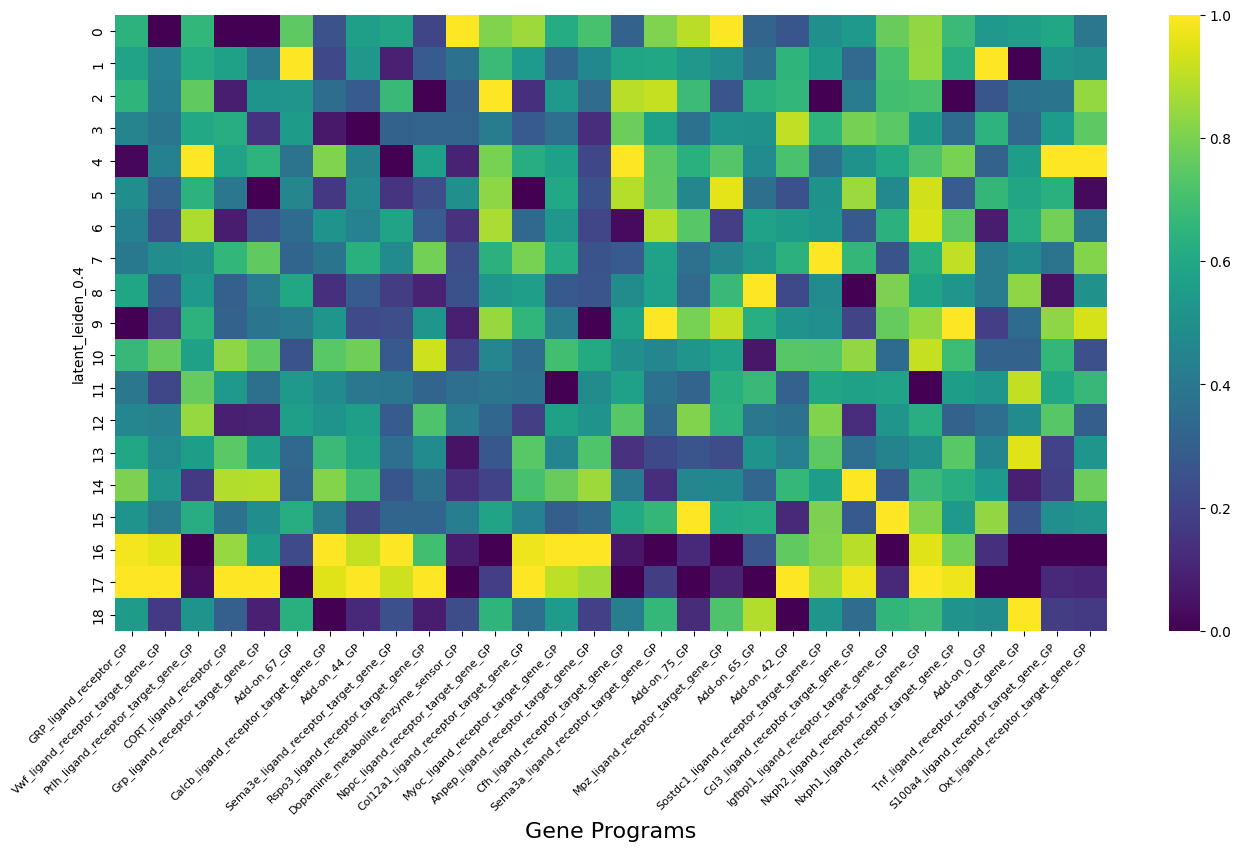

In [22]:
# Visualize GP activities of enriched GPs across niches
df = model.adata.obs[[latent_cluster_key] + enriched_gps].groupby(latent_cluster_key).mean()

scaler = MinMaxScaler()
normalized_columns = scaler.fit_transform(df)
normalized_df = pd.DataFrame(normalized_columns, columns=df.columns)
normalized_df.index = df.index

plt.figure(figsize=(16, 8))  # Set the figure size
ax = sns.heatmap(normalized_df,
            cmap='viridis',
            annot=False,
            linewidths=0)
plt.xticks(rotation=45,
           fontsize=8,
           ha="right"
          )
plt.xlabel("Gene Programs", fontsize=16)
plt.savefig(f"{figure_folder_path}/enriched_gps_heatmap.svg",
            bbox_inches="tight")

In [23]:
# Store gene program summary of enriched gene programs
save_file = True
file_path = f"{figure_folder_path}/" \
            f"/log_bayes_factor_{log_bayes_factor_thresh}_" \
            "niche_enriched_gps_summary.csv"

gp_summary_cols = ["gp_name",
                   "n_source_genes",
                   "n_non_zero_source_genes",
                   "n_target_genes",
                   "n_non_zero_target_genes",
                   "gp_source_genes",
                   "gp_target_genes",
                   "gp_source_genes_importances",
                   "gp_target_genes_importances"]

enriched_gp_summary_df = gp_summary_df[gp_summary_df["gp_name"].isin(enriched_gps)]
cat_dtype = pd.CategoricalDtype(categories=enriched_gps, ordered=True)
enriched_gp_summary_df.loc[:, "gp_name"] = enriched_gp_summary_df["gp_name"].astype(cat_dtype)
enriched_gp_summary_df = enriched_gp_summary_df.sort_values(by="gp_name")
enriched_gp_summary_df = enriched_gp_summary_df[gp_summary_cols]

if save_file:
    enriched_gp_summary_df.to_csv(f"{file_path}")
else:
    display(enriched_gp_summary_df)
    

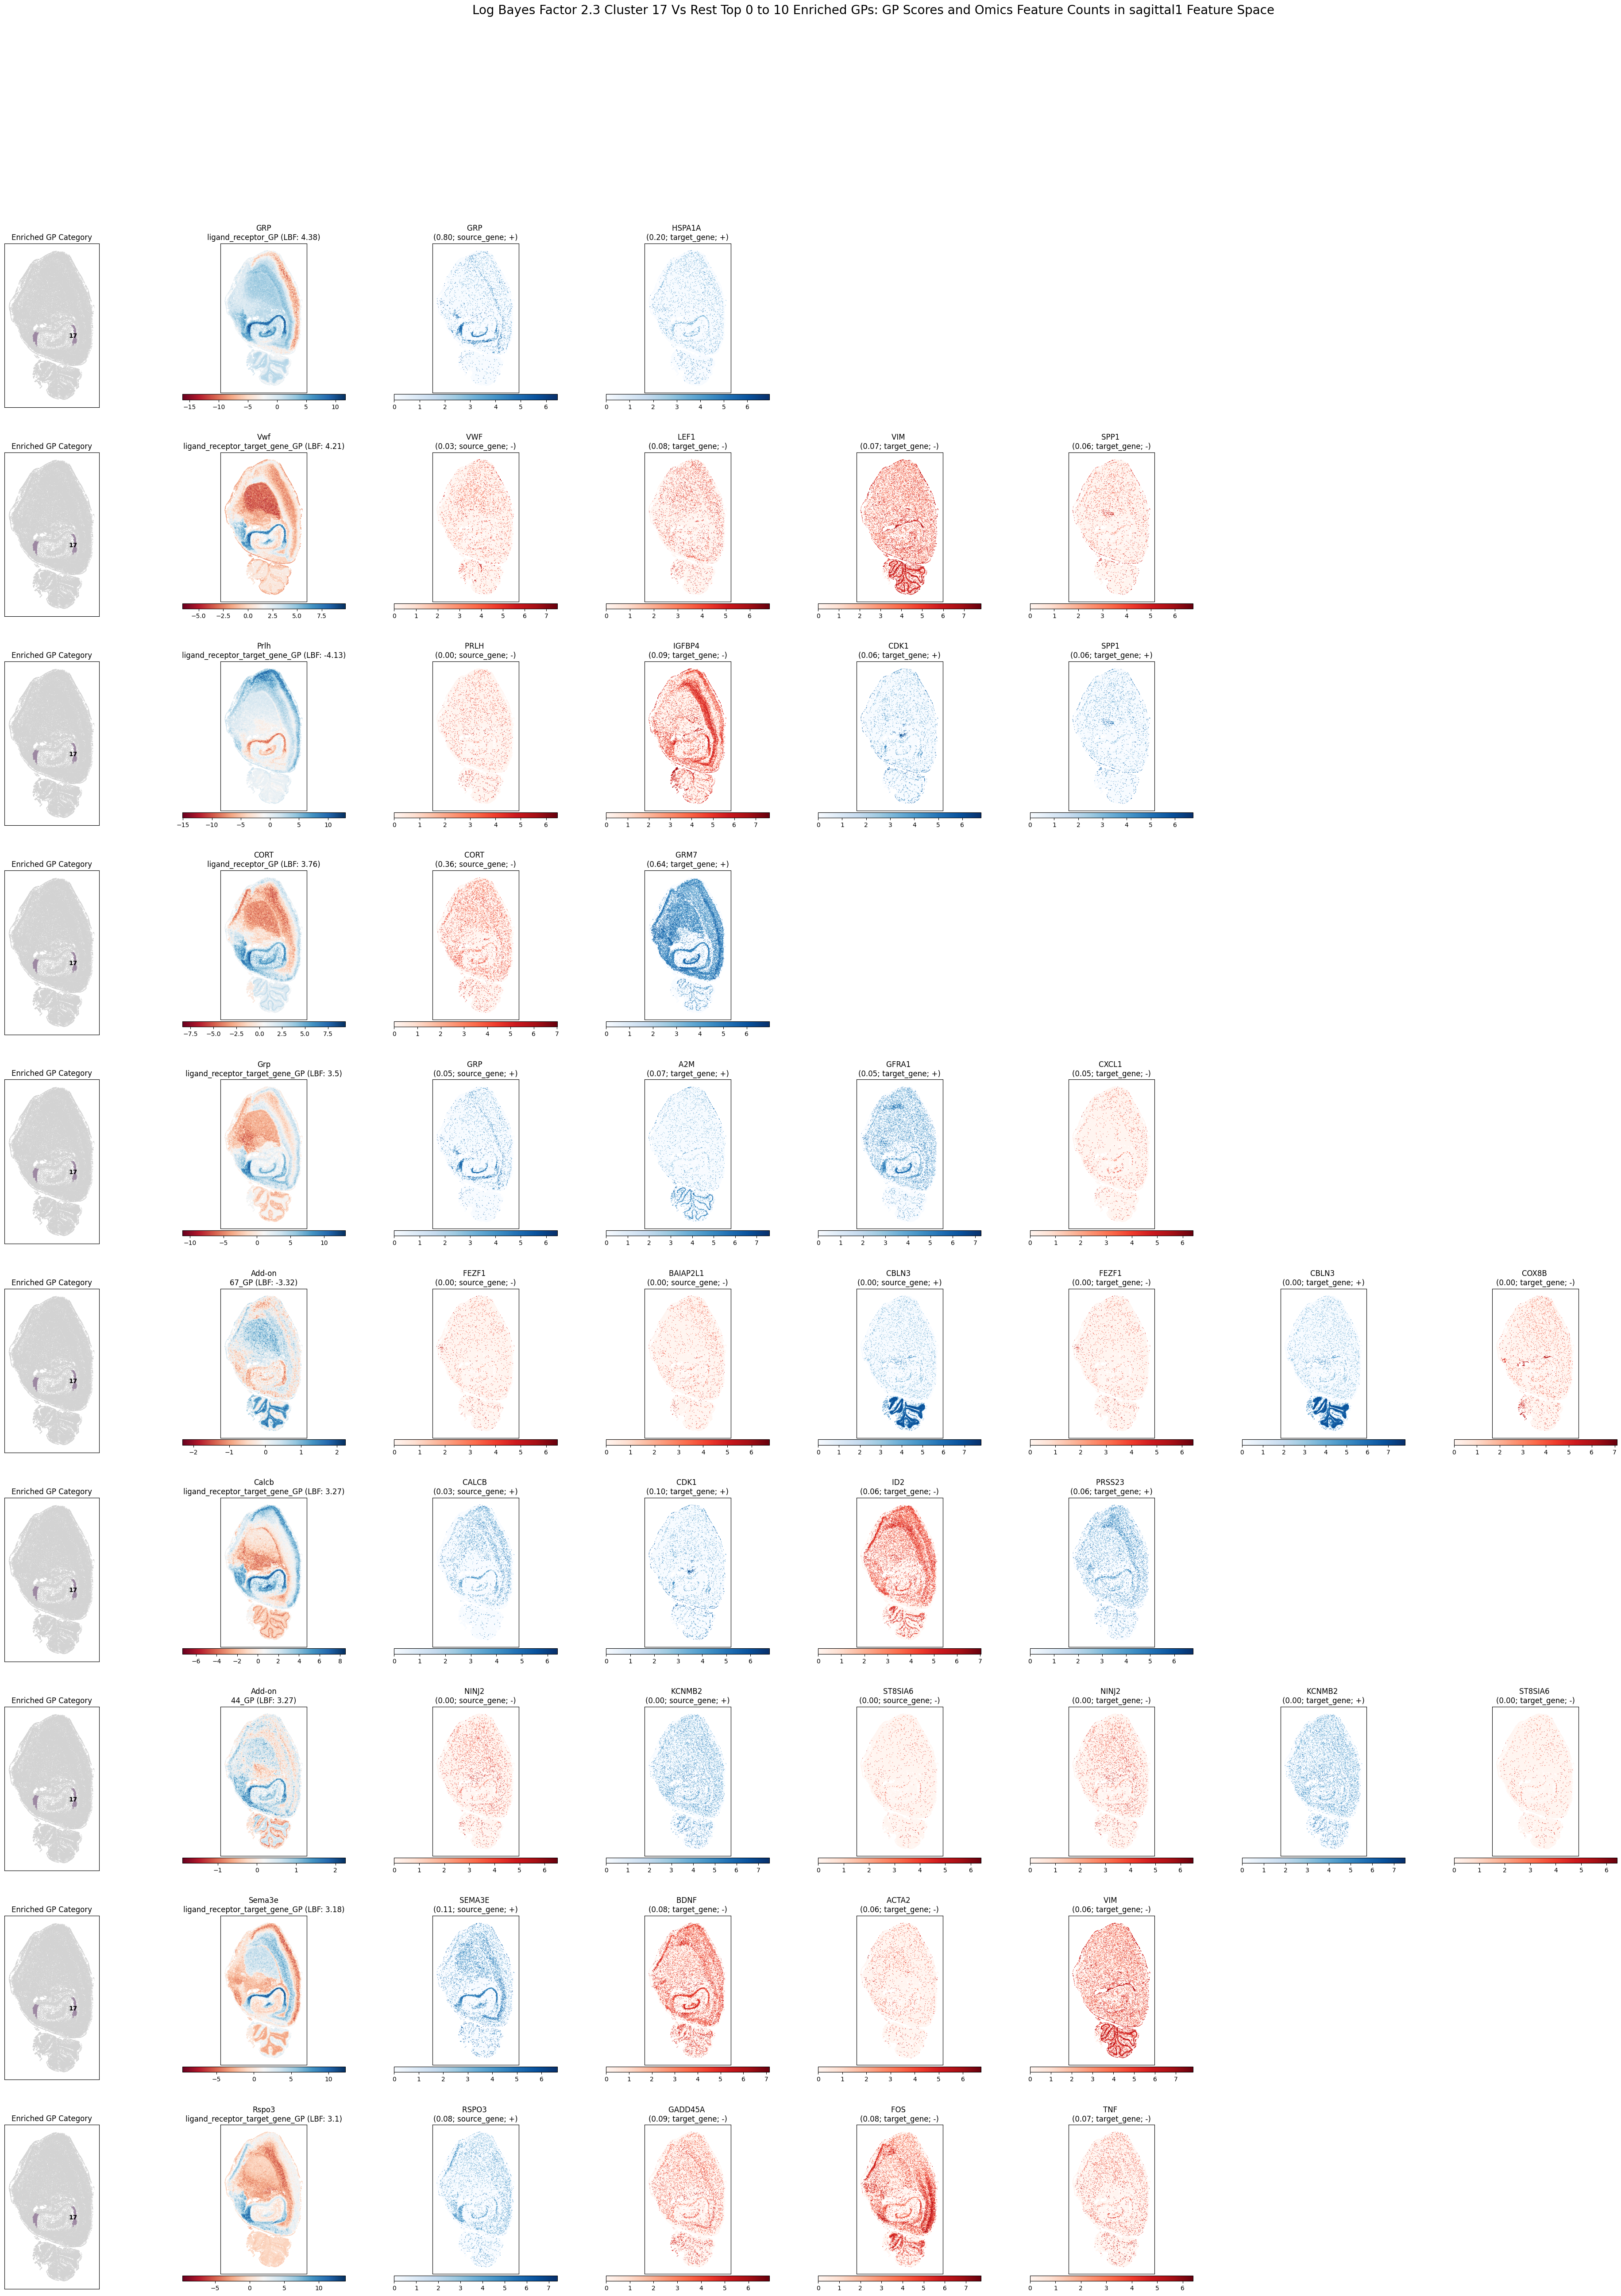

In [24]:
plot_label = f"log_bayes_factor_{log_bayes_factor_thresh}_cluster_{selected_cats[0]}_vs_rest"
save_figs = True

generate_enriched_gp_info_plots(
    plot_label=plot_label,
    model=model,
    sample_key=sample_key,
    differential_gp_test_results_key=differential_gp_test_results_key,
    cat_key=latent_cluster_key,
    cat_palette=latent_cluster_colors,
    n_top_enriched_gp_start_idx=0,
    n_top_enriched_gp_end_idx=10,
    feature_spaces=samples, # ["latent"]
    n_top_genes_per_gp=3,
    save_figs=save_figs,
    figure_folder_path=f"{figure_folder_path}/",
    spot_size=spot_size)

# Cell-cell Communication

In [25]:
gp_name = "Kl_ligand_receptor_target_gene_GP"

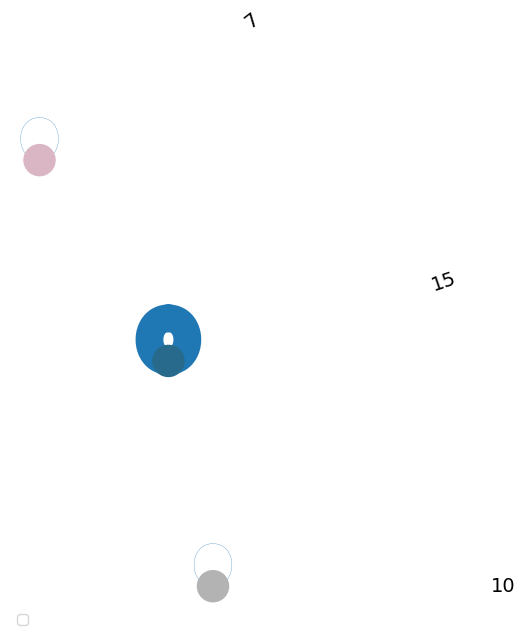

In [26]:
network_df = compute_communication_gp_network(
    gp_list=[gp_name],
    model=model,
    group_key=latent_cluster_key,
    n_neighbors=n_neighbors)

visualize_communication_gp_network(
    adata=model.adata,
    network_df=network_df,
    figsize=(3, 7),
    cat_colors=latent_cluster_colors,
    edge_type_colors=["#1f77b4"], 
    cat_key=latent_cluster_key,
    save=True,
    save_path=f"{figure_folder_path}/gp_network_{gp_name}.svg",
    )

In [28]:
model.adata

AnnData object with n_obs × n_vars = 91246 × 1022
    obs: 'Main_molecular_cell_type', 'Sub_molecular_cell_type', 'Main_molecular_tissue_region', 'Sub_molecular_tissue_region', 'Molecular_spatial_cell_type', 'batch', 'latent_leiden_0.4', 'GRP_ligand_receptor_GP', 'Vwf_ligand_receptor_target_gene_GP', 'Prlh_ligand_receptor_target_gene_GP', 'CORT_ligand_receptor_GP', 'Grp_ligand_receptor_target_gene_GP', 'Add-on_67_GP', 'Calcb_ligand_receptor_target_gene_GP', 'Add-on_44_GP', 'Sema3e_ligand_receptor_target_gene_GP', 'Rspo3_ligand_receptor_target_gene_GP', 'Dopamine_metabolite_enzyme_sensor_GP', 'Nppc_ligand_receptor_target_gene_GP', 'Col12a1_ligand_receptor_target_gene_GP', 'Myoc_ligand_receptor_target_gene_GP', 'Anpep_ligand_receptor_target_gene_GP', 'Cfh_ligand_receptor_target_gene_GP', 'Sema3a_ligand_receptor_target_gene_GP', 'Add-on_75_GP', 'Mpz_ligand_receptor_target_gene_GP', 'Add-on_65_GP', 'Add-on_42_GP', 'Sostdc1_ligand_receptor_target_gene_GP', 'Ccl3_ligand_receptor_target_gene_

In [29]:
gp_name = "Oxt_ligand_receptor_target_gene_GP"

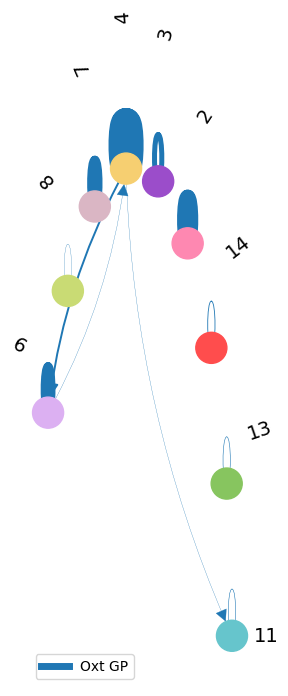

In [30]:
network_df = compute_communication_gp_network(
    gp_list=[gp_name],
    model=model,
    group_key=latent_cluster_key,
    n_neighbors=n_neighbors)

visualize_communication_gp_network(
    adata=model.adata,
    network_df=network_df,
    figsize=(3, 7),
    cat_colors=latent_cluster_colors,
    edge_type_colors=["#1f77b4"], 
    cat_key=latent_cluster_key,
    save=True,
    save_path=f"{figure_folder_path}/gp_network_{gp_name}.svg",
    )